<div class="alert alert-block alert-success"><h1>
<h1><b>
 Tugas Pengganti UAS - 2025
</b></h1>

**Mata Kuliah:** Komputasi Nuklir

**Tenggat Waktu:** Rabu, 31 Desember 2025, Pukul 23:59 WIB

**Petunjuk Pengumpulan:**
1.  Unduh dan pelajari deskripsi tugas dari eLOK.
2.  Susunlah kode sesuai deskripsi tugas tersebut pada sel yang telah ditentukan.
3.  Simpan *notebook* ini dengan format nama file: `Tugas_Pengganti_UAS_XXXXXX.ipynb`. XXXXXX adalah NIU Anda.
4.  Unggah *file* `.ipynb` yang sudah Anda kerjakan ke eLOK.


--- 
### Data Mahasiswa 

**Nama lengkap:** Ahmad Zulkifli Mahfuz

**NIM :** 23/519179/TK/57241

---

--- 
### Deklarasi Penggunaan Generative AI

Sesuai dengan kebijakan yang telah disampaikan di kelas, harap isi bagian di bawah ini dengan jujur.

**Apakah Anda menggunakan *Generative AI* (seperti ChatGPT, GitHub Copilot, dll.) dalam mengerjakan tugas ini?**

* [x] Ya
* [ ] Tidak

**Jika Ya, jelaskan secara spesifik bagaimana Anda menggunakannya (untuk tujuan apa, dan berikan  *prompt* yang diajukan):**

Generative AI digunakan untuk membantu koding python nya, bukan logika nya.

Contoh Prompt:
1. cara membuat kotak berwarna pada grafik xy
2. cara membaca file html
3. cara mencari indeks berdasarkan parameter pada mapping
4. cara membuat interpolasi dengan binary search

dsb

adapun logika dan alur berfikir, dilakukan tanpa bantuan Generative AI maupun orang lain

---


### **Tautan Video**

 `https://youtu.be/-kWfaEu_GZU`


--- 
### **Penyelesaian Tugas**

#### **1. Diagram Alir** 

*Tempelkan diagram alir (flowchart) program Monte Carlo untuk mensimulasikan gerakan dan interaksi neutron pada susunan geometri seperti yang telah dijelaskan pada deskripsi tugas.* 



![FlowChart](FlowChartMC.png)

#### **2. Program Monte Carlo**

*Tuliskan di sini program Monte Carlo untuk menyelesaiakan permasalahan sesuai deskripsi tugas. Susun definisi fungsi untuk menyelesaikan problem tertentu.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import sys
import time

In [2]:
def watt_spectrum_pdf(E_MeV):
    return 0.453 * np.exp(-1.036 * E_MeV) * np.sinh(np.sqrt(2.29 * E_MeV))

def watt_distribution_sampling(neutron_counts):
    samples = []
    count = 0
    max_pdf = 0.4 #puncak distribusi
    
    while count < neutron_counts:
        E_rand = np.random.uniform(0, 15)
        Y_rand = np.random.uniform(0, max_pdf)
        
        if Y_rand <= watt_spectrum_pdf(E_rand):
            samples.append(E_rand * 1e6)
            count += 1
    return np.array(samples)

In [3]:
def pos_particle(a, b, c, x, y):
    if (y >= 0) and (y <= c):
        if (x <= b+a) and (x >= b):
            A = 208 #Pb
            pos = 2
        elif (x <= b) & (x >= 0):
            A = 56 #Fe
            pos = 1
        elif (x <= 2*b+a) & (x >= b+a):
            A = 56 #Fe
            pos = 3
        else:
            A = 0
            pos = 0
    else:
        A = 0
        pos = 0
    return pos, A

In [4]:
def pass_boundary(x_old, y_old, x_new, y_new):
    pass_ = ""
    old_pos, _ = pos_particle(a, b, c, x_old, y_old)
    new_pos, _ = pos_particle(a, b, c, x_new, y_new)
    pass_ += str(old_pos)
    pass_ += str(new_pos)
    return pass_

In [5]:
def extrac_data(a, b): #a:material code, b: MT code
    material = {1: '2631', 2: '8237'}
    html_file = f"{material.get(a, 'unknown')}-{b}.html"
    
    with open(html_file, "r") as f:
        soup = BeautifulSoup(f, 'html.parser')
    pre_tag = soup.find('pre').text
    
    lines = pre_tag.splitlines()
    line = []
    
    for i in range (8, len(lines)-1):
        line.append(lines[i].split())
        
    column = line[0]
    row = line[1:]
    
    df = pd.DataFrame(row, columns = column)
    df.drop(columns=[column[2]], inplace=True)
    
    E_data = pd.to_numeric(df[column[0]].values)
    Sig_data = pd.to_numeric(df[column[1]].values)

    return E_data, Sig_data

In [6]:
def Sigma_count(E_data, Sig_data, E_target):
    Sig_target = np.interp(E_target, E_data, Sig_data)
    return Sig_target

In [7]:
def alpha_count(A):
    return ((A - 1) / (A + 1)) ** 2

In [8]:
def E_scatter(E, alpha, phi):
    return E * ((1 + alpha) + (1 - alpha) * np.cos(phi)) / 2

In [9]:
def russian_roulette(weight, w_cutoff=0.001, p_kill=0.5):
    if weight < w_cutoff:
        r = np.random.random()

        if r < p_kill:
            return 'dead', 0.0
        else:
            weight_boosted = weight / (1-p_kill)
            return 'alive', weight_boosted
    else:
        return 'alive', weight

In [ ]:
def neutron_sim(a, b, c, N_partikel, analog):
    start_time = time.time()
    counters = {'absorpsi A': 0, 'absorpsi B': 0, 'transmisi': 0}

    all_x_step = []
    all_y_step = []
    E_start = watt_distribution_sampling(N_partikel)
    E_A_escape = []
    E_B_escape = []
    all_status = []

    left_boundary = b
    right_boundary = a+b

    max_step = 50
    for i in range(0, N_partikel):
        w = 1.0
        
        x_step = []
        y_step = []
        E = E_start[i]

        status = 'unknown'  

        x = np.random.uniform(left_boundary, right_boundary)
        y = np.random.uniform(0, c)

        x_step.append(x)
        y_step.append(y)

        phi = np.random.uniform(0, 2*np.pi)
        mu_x = np.cos(phi)
        mu_y = np.sin(phi)
        
        alive = True
        pos = 2 #1: material B kiri, 2: material A, 3: material B kanan
        
        j = 0
        while alive:
            if pos == 1 or pos == 3:
                Sigma_t = Sigma_count(E_Al_t, Sig_Al_t, E)
                Sigma_s = Sigma_count(E_Al_s, Sig_Al_s, E)
            else:
                Sigma_t = Sigma_count(E_Pb_t, Sig_Pb_t, E)
                Sigma_s = Sigma_count(E_Pb_s, Sig_Pb_s, E)

            R = np.random.random()
            d = -np.log(R)/Sigma_t
            
            x_old = x
            y_old = y

            x += d*mu_x
            y += d*mu_y
            
            pre_pos = pos
            pos, A = pos_particle(a, b, c, x, y)
            pass_material = pass_boundary(x_old, y_old, x, y)       

            if pos == 0:
                if pass_material[0] == 1 or pass_material[0] == 3: E_B_escape.append(E)
                if pass_material[0] == '2': E_A_escape.append(E)
                counters['transmisi'] += w
                status = 'transmisi'
                alive = False

            if pass_material[0] == pass_material[1]:
                x_step.append(x)
                y_step.append(y)
            else:
                e = 1e-7
                if pass_material == "21" or pass_material == "12":
                    d_new = abs(x_old-left_boundary) / abs(mu_x)
                    x = left_boundary
                    if pass_material[1] == '1': x -= e
                    else: x += e
                    y = y_old + d_new*mu_y
                    continue
                else:
                    d_new = abs(right_boundary-x_old) / abs(mu_x)
                    x = right_boundary
                    if pass_material[1] == '3': x += e
                    else: x -= e
                    y = y_old + d_new*mu_y
                    continue

            P_scatter = Sigma_s / Sigma_t
            absorp = False
            if analog == True:
                P = np.random.random()
                if P <= P_scatter:
                    alpha = alpha_count(A)
                    phi = np.random.uniform(0, 2*np.pi)
                    E = E_scatter(E, alpha, phi)
    
                    mu_x = np.cos(phi)
                    mu_y = np.sin(phi)
                else:
                    absorp = True
                    fraksi_abs = 1
                    alive = False
            else:
                w = w * P_scatter
                status, w = russian_roulette(w)
    
                if status == 'dead':
                    alive = False
                else:
                    alpha = alpha_count(A)
                    phi = np.random.uniform(0, 2*np.pi)
                    E = E_scatter(E, alpha, phi)
    
                    mu_x = np.cos(phi)
                    mu_y = np.sin(phi)
    
                fraksi_abs = w * (1 - P_scatter)
                if fraksi_abs != 0: absorp = True

                if E < 0.025:
                    alive = False

            if absorp == True:
                if pos == 2:
                    counters['absorpsi A'] += fraksi_abs
                    status = 'absorpsi A'
                else:
                    counters['absorpsi B'] += fraksi_abs
                    status = 'absorpsi B'
            
            j+=1

        sys.stdout.write(f"\r{i}/{N_partikel}")
        sys.stdout.flush()
        if i < max_step:
            all_x_step.append(x_step)
            all_y_step.append(y_step)
            all_status.append(status)

    end_time = time.time()
    running_time = end_time - start_time
    print(f"\ntime: {running_time}")

    return counters, all_x_step, all_y_step, E_start, E_A_escape, E_B_escape, all_status

#### **3. Simulasi**

*Jalankan program yang Anda buat di bagian 2 di atas untuk mensimulasikan permasalahan sesuai deskripsi tugas. Tampilkan hasil dalam bentuk teks berupa fraksi neutron yang diserap dan yang lolos.*

In [14]:
a = 15 #tebal Pb
b = 45 #tebal Fe
c = 45 #tinggi material
partikel = 100000
analog = bool(1)

E_Al_t, Sig_Al_t = extrac_data(1, 1)
E_Al_s, Sig_Al_s = extrac_data(1, 2)
E_Pb_t, Sig_Pb_t = extrac_data(2, 1)
E_Pb_s, Sig_Pb_s = extrac_data(2, 2)

result, traces_x, traces_y, E_start, E_A, E_B, traces_stat = neutron_sim(a, b, c, partikel, analog)

print(f"fraksi neutron yang diserap di material A: {result['absorpsi A']/partikel:.3f} ({result['absorpsi A']:.3f} partikel)")
print(f"fraksi neutron yang diserap di material B: {result['absorpsi B']/partikel:.3f} ({result['absorpsi B']:.3f} partikel)")
print(f"fraksi neutron yang lolos dari material A: {(result['transmisi'] + result['absorpsi B'])/partikel:.3f} ({(result['transmisi'] + result['absorpsi B']):.3f} partikel)")
print(f"fraksi neutron yang lolos dari material B: {result['transmisi']/partikel} ({result['transmisi']:.3f} partikel)")

99999/100000
time: 2679.5502173900604
fraksi neutron yang diserap di material A: 0.538 (53766.000 partikel)
fraksi neutron yang diserap di material B: 0.277 (27732.000 partikel)
fraksi neutron yang lolos dari material A: 0.462 (46234.000 partikel)
fraksi neutron yang lolos dari material B: 0.18502 (18502.000 partikel)


In [15]:
print(f"absorpsi A: {result['absorpsi A']}")
print(f"absorpsi B: {result['absorpsi B']}")
print(f"transmisi: {result['transmisi']}")

absorpsi A: 53766
absorpsi B: 27732
transmisi: 18502.0


#### **4. Visualisasi Hasil**

*Tampilkan hasil dalam bentuk grafis berupa histogram energi neutron dan jejak lintasan partikel sejak dilahirkan sampai diserap atau bocor ke luar material.*

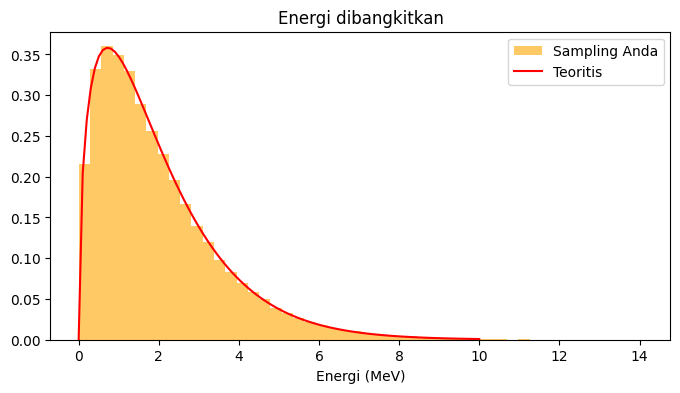

In [16]:
if len(E_start) > 0:
    plt.figure(figsize=(8, 4))
    plt.hist(E_start/1e6, bins=50, density=True, color='orange', alpha=0.6, label='Sampling Anda')
    E_axis = np.linspace(0, 10, 100)
    plt.plot(E_axis, watt_spectrum_pdf(E_axis), 'r-', label='Teoritis')
    plt.xlabel('Energi (MeV)')
    plt.title('Energi dibangkitkan')
    plt.legend()
    plt.show()
else: print("no particle")

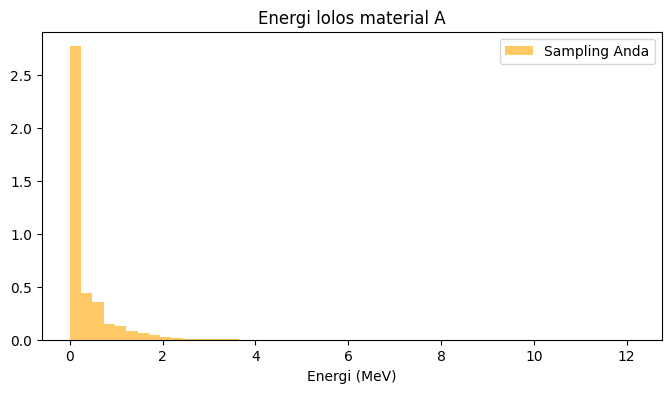

In [17]:
if len(E_A) > 0:
    plt.figure(figsize=(8, 4))
    plt.hist(np.array(E_A)/1e6, bins=50, density=True, color='orange', alpha=0.6, label='Sampling Anda')
    #E_axis = np.linspace(0, 10, 100)
    #plt.plot(E_axis, watt_spectrum_pdf(E_axis), 'r-', label='Teoritis')
    plt.xlabel('Energi (MeV)')
    plt.title('Energi lolos material A')
    plt.legend()
    plt.show()
else: print("no particle")

In [18]:
if len(E_B) > 0:
    plt.figure(figsize=(8, 4))
    plt.hist(np.array(E_B)/1e6, bins=50, density=True, color='orange', alpha=0.6, label='Sampling Anda')
    #E_axis = np.linspace(0, 10, 100)
    #plt.plot(E_axis, watt_spectrum_pdf(E_axis), 'r-', label='Teoritis')
    plt.xlabel('Energi (MeV)')
    plt.title('Energi lolos material B')
    plt.legend()
    plt.show()
else: print("no particle")

no particle


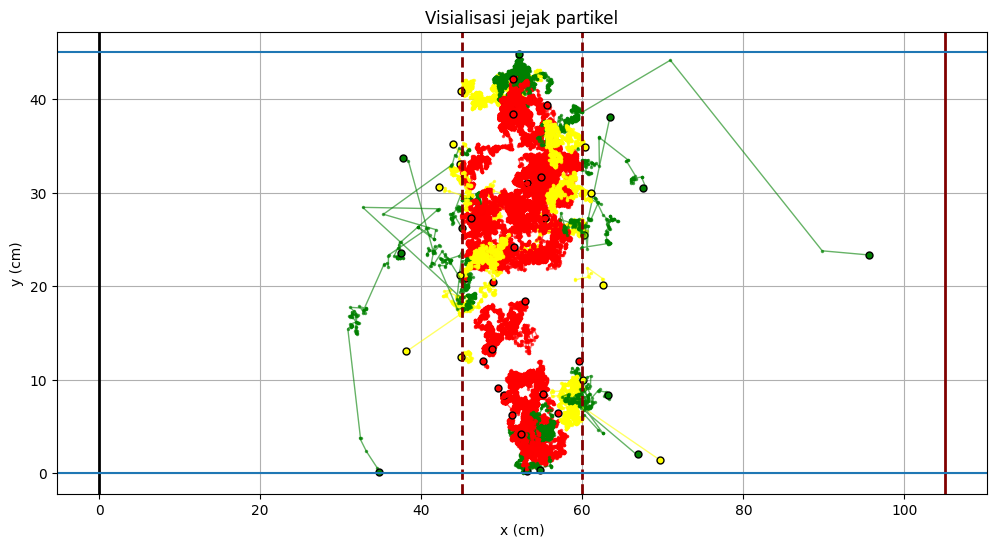

In [19]:
if len(traces_x) > 0:
    plt.figure(figsize=(12, 6))
    colors = {'transmisi': 'green', 'absorpsi A': 'red', 'absorpsi B': 'yellow'}
    
    for x_path, y_path, stat in zip(traces_x, traces_y, traces_stat):
        plt.plot(
            x_path, y_path, marker='.', markersize=3,
            color=colors.get(stat, 'black'), alpha=0.6, linewidth=1,
        )
        plt.plot(
            x_path[-1], y_path[-1], 'o',
            markersize=5, color=colors.get(stat, 'black'),
            markeredgecolor='black',
            markeredgewidth=1
        )

    plt.axvline(0, color='black', linewidth=2, label='Permukaan Masuk')
    plt.axvline(45, color='maroon', linestyle='--', linewidth=2, label='Permukaan Keluar')
    plt.axvline(60, color='maroon', linestyle='--', linewidth=2, label='Permukaan Keluar')
    plt.axvline(105, color='maroon', linewidth=2, label='Permukaan Keluar')
    plt.axhline(c, xmin=0, xmax=c)
    plt.axhline(0, xmin=0, xmax=c)
    
    plt.title(f'Visialisasi jejak partikel')
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    plt.grid(True)
    
    plt.show()

#### **5. Kesimpulan**

*Tulislah kesimpulan berdasar hasil simulasi Anda*

...